In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from numba import jit

In [2]:
def signum(midpoint, matrix): #signum function for testing the diffusion initially
    for i in range(len(matrix)):
        for j in range(len(matrix[i])):
            if j < midpoint:
                c1[i][j] = 1
            else:
                c1[i][j] = -1

@jit(nopython=True)                             # Setting "nopython" mode for best performance
def diffuse(amount, matrix, in_x_direction):    # Function is compiled to machine code when called the first time
    #firstly i tried this different diffusion approach, did not yield good results. Now p_diffuse is used, down below.
    #if want to use constant weights, these below should be used. In for loops, all w1, w2 should be commented out then
    w1 = amount
    w2 = 1-w1
    
    for i in range(N): #diffuses from left to right i think
        for j in range(N):
            
            if in_x_direction: #if transformation was made horizontally
                #w1 = a*np.cos(j*np.pi*2/N) - math.floor(a*np.cos(j*np.pi*2/N))
                #w2 = 1-w1
                matrix[i][j] = w1*matrix[i][j-1] + w2*matrix[i][j]
            else: #else => transformation was made vertically
                #w1 = a*np.cos(i*np.pi*2/N) - math.floor(a*np.cos(i*np.pi*2/N))
                #w2 = 1-w1
                matrix[i][j] = w1*matrix[i-1][j] + w2*matrix[i][j]
            
    if in_x_direction:
        matrix = matrix.T[::-1].T #reverses array
    else:
        matrix = matrix[::-1]

    for i in range(N): #diffuses from right to left (?)
        for j in range(N):

            if in_x_direction:
                #w1 = a*np.cos(j*np.pi*2/N) - math.floor(a*np.cos(j*np.pi*2/N))
                #w2 = 1-w1
                matrix[i][j] = w1*matrix[i][j-1] + w2*matrix[i][j]
            else:
                #w1 = a*np.cos(i*np.pi*2/N) - math.floor(a*np.cos(i*np.pi*2/N))
                #w2 = 1-w1
                matrix[i][j] = w1*matrix[i-1][j] + w2*matrix[i][j]


In [3]:
@jit(nopython=True) # Setting "nopython" mode for best performance
def p_diffuse(matrix, in_x_direction): # Function is compiled to machine code when called the first time
    #pixel diffuse, should be right approach
    new_matrix = np.zeros((N,N))
    for i in range(N): 
        for j in range(N):
            
            if in_x_direction: #if transformation was made horizontally
                w1 = a*np.cos(j*np.pi*2/N) - math.floor(a*np.cos(j*np.pi*2/N))
                w2 = 1-w1
                new_matrix[i][j] = w1*matrix[i][j-1] + w2*matrix[i][j] + c_init[i][j]#here we add original sine again
            else: #else => transformation was made vertically
                w1 = a*np.cos(i*np.pi*2/N) - math.floor(a*np.cos(i*np.pi*2/N))
                w2 = 1-w1
                new_matrix[i][j] = w1*matrix[i-1][j] + w2*matrix[i][j] + c_init[i][j]#here we add original sine again
            
    return(new_matrix)

In [4]:
@jit(nopython=True) # Setting "nopython" mode for best performance
def iterate(no_of_times, c_old): # Function is compiled to machine code when called the first time
    #must give in initial matrix
    c = np.zeros((N,N))
    for k in range(no_of_times):
        for i in range(N):
            for j in range(N):
                if(k%2==0): #even => mixes one way, odd => another way
                    c[i][j] = c_old[i][(j+int(a*np.cos(i*np.pi*2/N))) & N-1]
                else:
                    c[i][j] = c_old[(i+int(a*np.cos(j*np.pi*2/N))) & N-1][j]
        #diffuse(amount, c, k%2==0)
        c = p_diffuse(c, k%2==0)
        
        for i in range(N): #put elements of new matrix into the old one, couninue changing matrix c.
            for j in range(N):
                c_old[i][j] = c[i][j]
    return c

In [5]:
"""
Here is where Numba will show its true colors.
Running this on my old HP laptop took roughly 6 min 30 s.

But with Numba, this section will run in under 10 s.
That is roughly a 40x speedup.

Specs:
Memory      8GiB
Processor   AMD A8-7410 APU with AMD Radeon™ R5 Graphics × 4
"""
N = 512 #pildi lahutus
a = 200 #transformation strength, 200 seemed to give good Batchelor's law
#amount = 0.6 #diffusion amount if constant weights are used, 0 = none, 1 = too much
c1 = np.zeros((N,N))
c_init = np.zeros((N,N)) #for the iterate() function
#signum(int(N/2), c1)
#four lines below are for initial sine
for i in range(N): #same code that was in lecture: initial sine
        for j in range(N):
            c1[i][j] = np.sin(j*np.pi*2/N) #sine on i-axis
            c_init[i][j] = np.sin(j*np.pi*2/N) #same sine for the iterate() command, stays constant.
            #diffuse(amount, c1, True)
c_final = iterate(41, c1) #does adding and mixing process 41 times, gives out only final picture. takes a minute or so in jupyterhub, i have no loading screen.

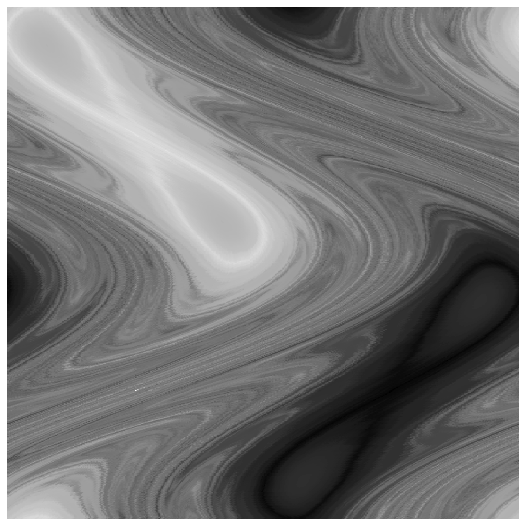

In [6]:
#visualization cell

px = 1/72# pixel in inches
plt.subplots(figsize=(660*px, 678*px)) #width, height. These numbers give exactly 512x512 pixel image, therefore containing no aliasing(?) errors, painstakingly adjusted through much trial and error

#fig = plt.figure(figsize=(5,5), dpi = 128) #lim dpi = ca 156 kanti
#for now it is in grayscale, can change
colbar = plt.imshow(c_final, cmap='gray', interpolation='none', extent=[0, N, 0, N], origin='lower', aspect='auto')
#plt.clim(-1, 1) #fixes limits of color bar
#cmap variants: Greys, hot, terrain, rainbow, cividis, viridis, gray. last one most similar to lecture example
#fig.colorbar(colbar)
plt.axis('off')

plt.savefig('my_fig.png', dpi=72, bbox_inches='tight') #should save the image in working folder, with small borders that need to be cropped out manually

plt.show()

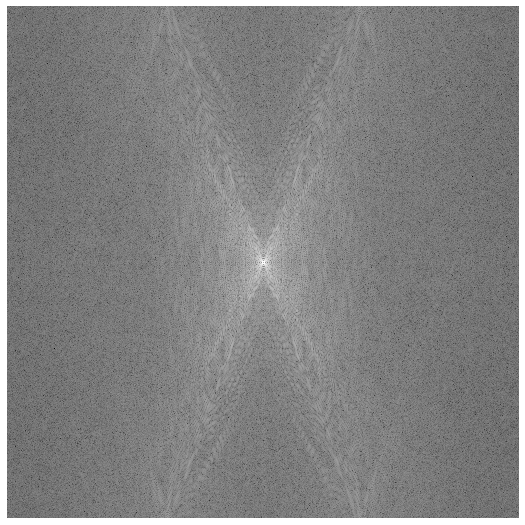

512


In [7]:
#fourier transform stuff just to check, I did mine in imageJ

fourier = abs(np.fft.fftshift(np.fft.fft2(c_final)))**2 #https://towardsdatascience.com/image-processing-with-python-application-of-fourier-transformation-5a8584dc175b
px = 1/72# pixel in inches
plt.subplots(figsize=(660*px, 678*px)) #width, height. These numbers give exactly 512x512 pixel image, therefore containing no aliasing errors, painstakingly adjusted through much trial and error
colbar = plt.imshow(np.log(fourier), cmap='gray')
#colbar = plt.imshow(abs(fourier), cmap='gray')

#fig.colorbar(colbar)
#print(fourier)

plt.axis('off')

plt.savefig('fourier.png', dpi=72, bbox_inches='tight')

plt.show()
print(len(fourier[0]))

In [8]:
#this code below is older, for seeing mixing after 2-6 steps. 
c2 = np.zeros((N,N)) #tegin kõik transformatsioonid eraldi: ei leidnud esialgu mõtet eraldi fuktsiooni kirjutama hakata
for i in range(N): #esimene transformatsioon koosinusega, j-teljel
    for j in range(N):
        c2[i][j] = c1[i][(j+int(a*np.cos(i*np.pi*2/N))) & N-1]
#diffuse(amount, c2, True)
c2 = p_diffuse(c2, True)

In [9]:
#these cells below are older, if want to run these, run cells 1-3, 4 w/o the iterate() row and cell 5, then these
#then can plot c1 - c6 in visualization cell. useful for understanding process. note here is also initial sine added every time step.

c3 = np.zeros((N,N))
for i in range(N):
    for j in range(N):
        c3[i][j] = c2[(i+int(a*np.cos(j*np.pi*2/N))) & N-1][j]
        #c3[i][j] = c2[i][(j+int(a*np.cos(i*np.pi*2/N))) & N-1]
#diffuse(amount, c3, False)

c3 = p_diffuse(c3, False)
#c3 = p_diffuse(c3, True)

In [10]:
c4 = np.zeros((N,N))
for i in range(N):
    for j in range(N):
        c4[i][j] = c3[i][(j+int(a*np.cos(i*np.pi*2/N))) & N-1]
#diffuse(amount, c4, True)
c4 = p_diffuse(c4, True)

In [11]:
c5 = np.zeros((N,N))
for i in range(N):
    for j in range(N):
        c5[i][j] = c4[(i+int(a*np.cos(j*np.pi*2/N))) & N-1][j]
        #c5[i][j] = c4[i][(j+int(a*np.cos(i*np.pi*2/N))) & N-1]
#diffuse(amount, c5, False)
c5 = p_diffuse(c5, False)
#c5 = p_diffuse(c3, True)

In [12]:
c6 = np.zeros((N,N))
for i in range(N):
    for j in range(N):
        c6[i][j] = c5[i][(j+int(a*np.cos(i*np.pi*2/N))) & N-1]
#diffuse(amount, c6, True)
c6 = p_diffuse(c6, True)